#### Consistency/gap variable analysis

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from IPython.display import display, HTML

In [3]:
folder = '/root/capsule/data/filtered_data_session/filtered_data_101724.csv' # Updated** as of 10/17/24
main_df = pd.read_csv(folder)

/tmp/ipykernel_7243/3852814485.py:2: DtypeWarning: Columns (6,7,8,26,27,28,29,30,146,147,148,149,150,151,152,153,154,155,156,157,158) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv(folder)


In [4]:
# Let's look at individual trainer foraging performance scores first 
df = main_df[['subject_id', 'user_name', 'foraging_performance', 'session_date', 'curriculum_name']]

# Convert session_date to dates 
df['session_date'] = pd.to_datetime(df['session_date'])
df = df.sort_values(by=['subject_id', 'session_date'])

# Curriculum filter
df = df[df['curriculum_name'].isin(['Uncoupled Baiting'])]

# User filter 
user = 'Bowen Tan'
select_df = df[df['user_name'] == user]

df

/tmp/ipykernel_7243/1535511749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['session_date'] = pd.to_datetime(df['session_date'])


,subject_id,user_name,foraging_performance,session_date,curriculum_name
4006,703548,Ella Hilton,0.121779,2024-02-05,Uncoupled Baiting
3986,703548,Ella Hilton,0.432306,2024-02-06,Uncoupled Baiting
3979,703548,Ella Hilton,0.594106,2024-02-07,Uncoupled Baiting
3959,703548,Ella Hilton,0.677678,2024-02-08,Uncoupled Baiting
3938,703548,Ella Hilton,0.769231,2024-02-09,Uncoupled Baiting
...,...,...,...,...,...
148,754375,Avalon Amaya,0.359801,2024-10-10,Uncoupled Baiting
37,764769,Avalon Amaya,0.632962,2024-10-15,Uncoupled Baiting
10,764769,Avalon Amaya,0.754620,2024-10-16,Uncoupled Baiting
39,764787,Avalon Amaya,0.208333,2024-10-15,Uncoupled Baiting


In [5]:
def identify_multiple_trainers(df):
    """ 
    Finds subjects with multiple users

    Input: df with 'user_name' and 'subject_id'
    Output: df with 'subject_id', 'multiple_trainers' (boolean), 'trainer_count' (how many), 'trainer_list' (who)
    """ 

    # Count unique users per subject
    trainer_analysis = (df.groupby('subject_id')
                            .agg({'user_name': lambda x: [len(set(x)), list(set(x))]
                            })
                            .reset_index())

    trainer_analysis[['trainer_count', 'trainer_list']] = pd.DataFrame(
                    trainer_analysis['user_name'].tolist(), index=trainer_analysis.index
    )

    result_df = pd.DataFrame({
        'subject_id': trainer_analysis['subject_id'],
        'multiple_trainers': trainer_analysis['trainer_count'] > 1,
        'trainer_count': trainer_analysis['trainer_count'],
        'trainer_list': trainer_analysis['trainer_list']
    })

    return result_df

In [6]:
multiple_trainers_df = identify_multiple_trainers(df)

multiple_trainers_df

,subject_id,multiple_trainers,trainer_count,trainer_list
0,703548,True,2,"[Ella Hilton, Kanghoon Jung]"
1,704151,True,4,"[Ella Hilton, Travis Ramirez, Kanghoon Jung, A..."
2,712031,True,3,"[Ella Hilton, Huy Nguyen, Henry Loeffler]"
3,713377,False,1,[Ella Hilton]
4,716866,False,1,[Xinxin Yin]
...,...,...,...,...
63,753125,True,2,"[Bowen Tan, Xinxin Yin]"
64,753126,True,2,"[Bowen Tan, Xinxin Yin]"
65,754375,False,1,[Avalon Amaya]
66,764769,False,1,[Avalon Amaya]


In [7]:
def calculate_training_consistency(df):
    """
   Calculate training consistency metrics + mean foraging values associated 
    
    input: df with columns ['subject_id', 'user_name', 
                         'foraging_performance', 'session_date', 'curriculum_name']
    
    returns df with training consistency metrics
    """

    # Check for date-time format 
    df['session_date'] = pd.to_datetime(df['session_date'])
    
    # Group by subject_id and user_name
    consistency_metrics = df.groupby(['subject_id', 'user_name']).agg({
        'session_date': [
            ('date_range', lambda x: (x.max() - x.min()).days + 1),
            ('first_session', 'min'),
            ('last_session', 'max'),
            ('days_between_sessions', lambda x: x.diff().mean().days)
        ],
        'foraging_performance': [
            ('training_days', 'count'), # Since we are counting training days as everytime a FP value is submitted
            ('mean_performance', 'mean'),
            ('std_performance', 'std')
        ]
    }).reset_index()
    
    # Flatten column names for easier naming
    consistency_metrics.columns = [
        f'{col[0]}_{col[1]}' if col[1] else col[0] 
        for col in consistency_metrics.columns
    ]
    
    # Calculate main training consistency metric = training days / total date range for a given subject
    consistency_metrics['training_consistency'] = (
        consistency_metrics['foraging_performance_training_days'] / 
        consistency_metrics['session_date_date_range']
    )
    
    # Calculate training regularity 
    consistency_metrics['training_regularity'] = 1 / (
        1 + consistency_metrics['session_date_days_between_sessions']
    )
    
    # If only one session, set consistency to 1 and regularity to 1
    single_session_mask = consistency_metrics['foraging_performance_training_days'] == 1
    consistency_metrics.loc[single_session_mask, 'training_consistency'] = 1
    consistency_metrics.loc[single_session_mask, 'training_regularity'] = 1
    
    # Calculate days since last session
    current_date = df['session_date'].max() # Assuming most recent date is current (as of 10/17/24)
    consistency_metrics['days_since_last_session'] = (
        current_date - consistency_metrics['session_date_last_session']
    ).dt.days
    
    
    # Calculate 'performance trend'
    performance_trends = []
    for _, group in df.groupby(['subject_id', 'user_name']):
        if len(group) >= 2:
            # Calculate correlation between date and performance (+ = improving, - = declining)
            correlation = group['session_date'].astype(np.int64).corr(
                group['foraging_performance']
            )
            performance_trends.append(correlation)
        else:
            performance_trends.append(np.nan)
    
    consistency_metrics['performance_trend'] = performance_trends
    
    # Round float columns
    float_columns = consistency_metrics.select_dtypes(include=['float64']).columns
    consistency_metrics[float_columns] = consistency_metrics[float_columns].round(3)
    
    return consistency_metrics[['subject_id', 'user_name', 
                              'session_date_date_range', 'foraging_performance_training_days',
                              'training_consistency', 'training_regularity',
                              'foraging_performance_mean_performance',
                              'foraging_performance_std_performance',
                              'performance_trend', 'days_since_last_session',
                              'session_date_first_session', 'session_date_last_session']]



In [8]:
consistency_results = calculate_training_consistency(df) # Make calculations for whole dataset 

# Add multiple trainers column 
consistency_results = consistency_results.merge(
    multiple_trainers_df[['subject_id', 'multiple_trainers']], on='subject_id', how='left'
)

#display(HTML(consistency_results.to_html()))
consistency_results.head()

,subject_id,user_name,session_date_date_range,foraging_performance_training_days,training_consistency,training_regularity,foraging_performance_mean_performance,foraging_performance_std_performance,performance_trend,days_since_last_session,session_date_first_session,session_date_last_session,multiple_trainers
0,703548,Ella Hilton,43,21,0.488,0.333,0.685,0.156,0.583,212,2024-02-05,2024-03-18,True
1,703548,Kanghoon Jung,2,2,1.000,0.500,0.768,0.038,1.000,210,2024-03-19,2024-03-20,True
2,704151,Avalon Amaya,2,2,1.000,0.500,0.271,0.140,1.000,251,2024-02-07,2024-02-08,True
3,704151,Ella Hilton,15,7,0.467,0.333,0.663,0.152,0.797,202,2024-03-14,2024-03-28,True
4,704151,Kanghoon Jung,1,1,1.000,1.000,0.589,NaN,NaN,201,2024-03-29,2024-03-29,True


<Axes: xlabel='session', ylabel='foraging_performance'>

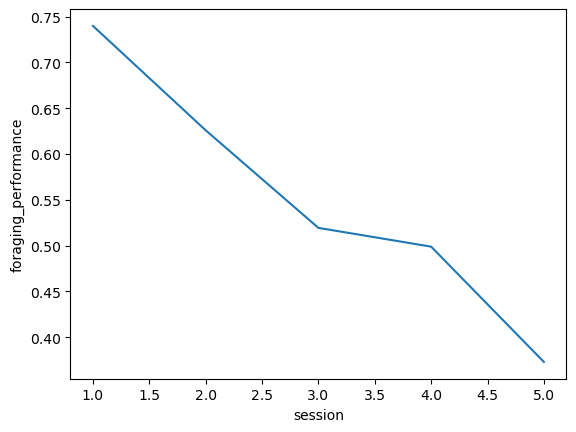

In [9]:
testing1 = main_df[main_df['subject_id'] == 663612]

sns.lineplot(testing1, x='session', y='foraging_performance')

<Axes: xlabel='training_consistency', ylabel='foraging_performance_mean_performance'>

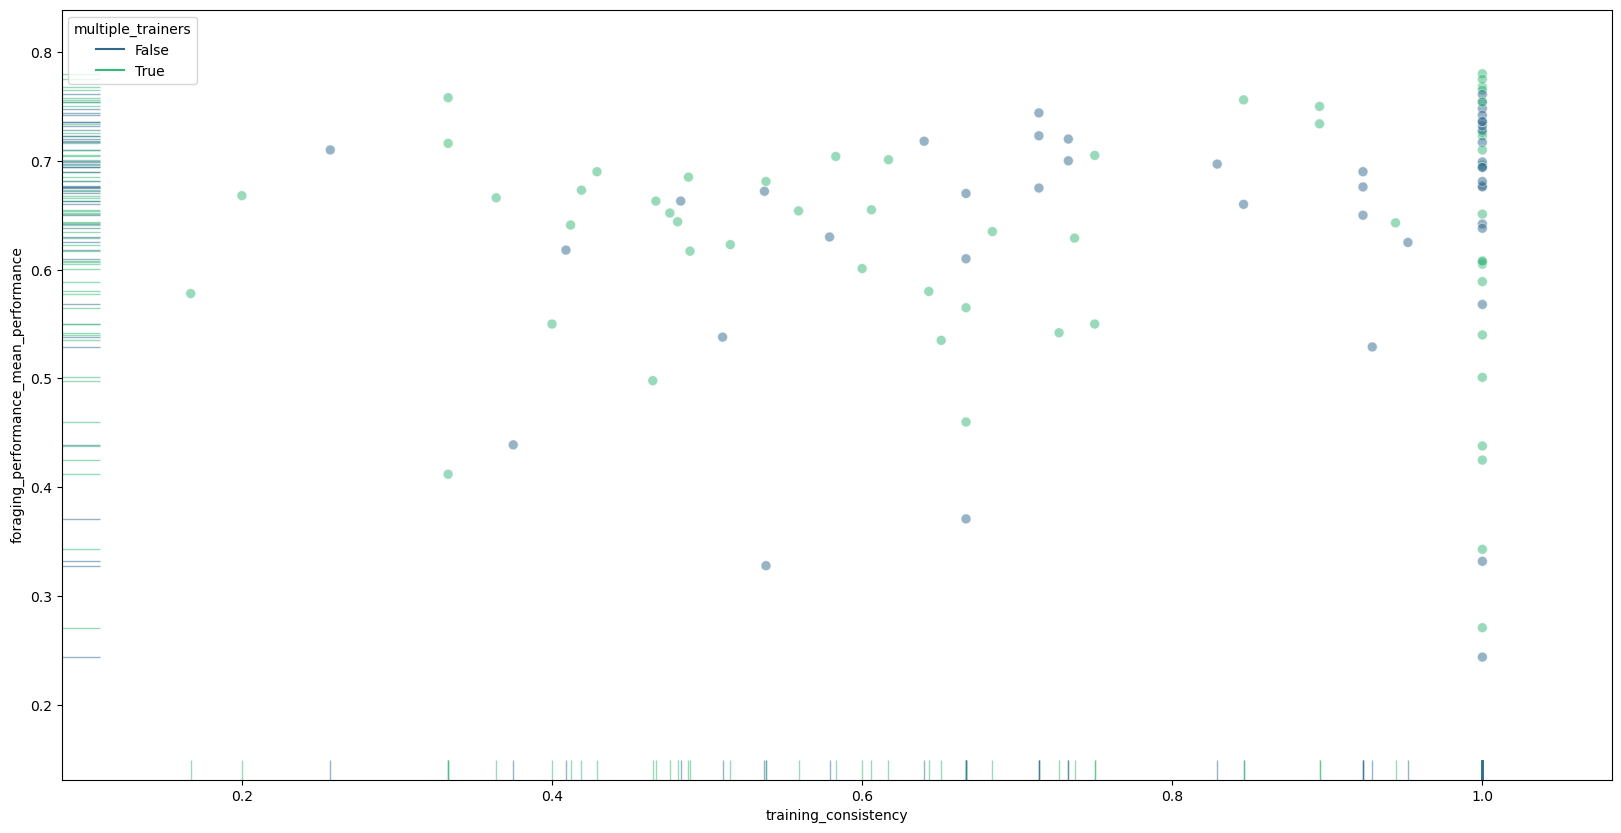

In [10]:
# Visualize overall relationship 

plt.rcParams['image.cmap'] = 'viridis'
plt.figure(figsize=(20,10))
sns.scatterplot(data=consistency_results, y='foraging_performance_mean_performance', x='training_consistency', hue='multiple_trainers', palette = 'viridis', s=50, alpha=0.5)
sns.rugplot(data=consistency_results, y='foraging_performance_mean_performance', x='training_consistency', hue='multiple_trainers', palette = 'viridis', clip_on=True, alpha=0.5)

<Figure size 2000x600 with 0 Axes>

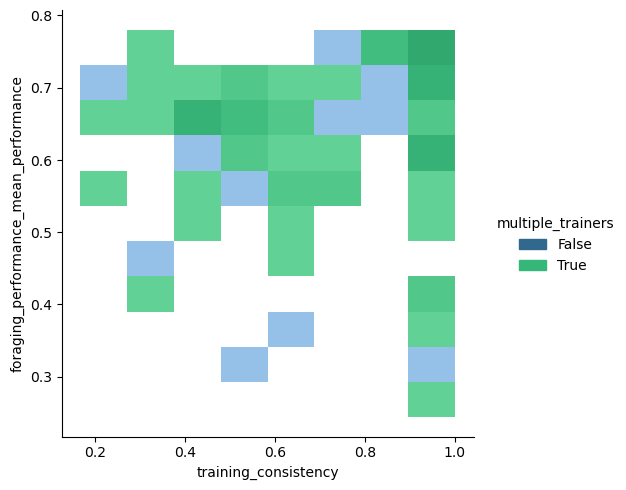

In [11]:
# Visualize distribution / density 

plt.figure(figsize=(20,6))
sns.displot(data=consistency_results, x='training_consistency', y='foraging_performance_mean_performance', palette='viridis', hue='multiple_trainers')

<Figure size 2000x1000 with 0 Axes>

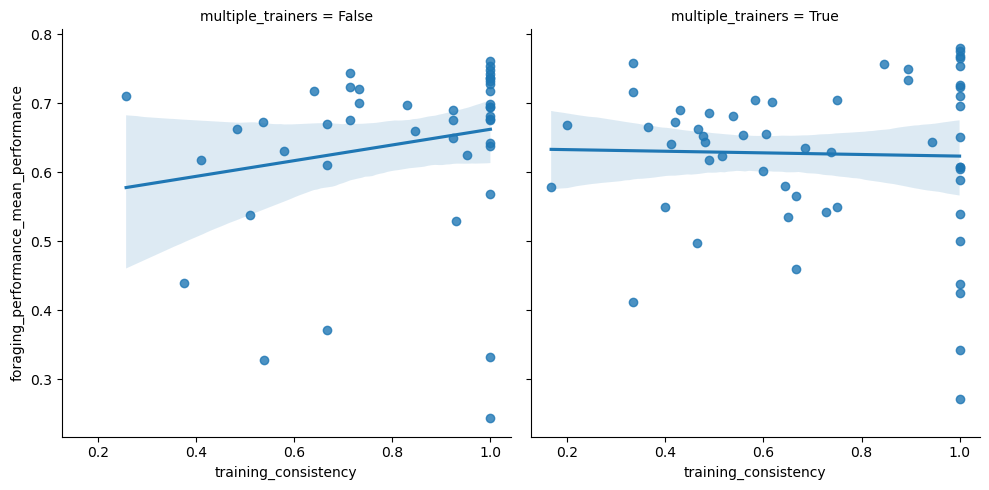

In [12]:
# LR plots

plt.figure(figsize=(20,10))
sns.lmplot(data=consistency_results, x='training_consistency', y='foraging_performance_mean_performance', col='multiple_trainers')

In [13]:
# Calculate correlation

for trainer in consistency_results['multiple_trainers'].unique():
    subset = consistency_results[consistency_results['multiple_trainers'] == trainer]

    pearson_corr, _ = pearsonr(subset['training_consistency'], subset['foraging_performance_mean_performance'])
    spearman_corr, _ = spearmanr(subset['training_consistency'], subset['foraging_performance_mean_performance'])

    print(f'multiple trainers: {trainer}:')
    print(f'    Pearson corr: {pearson_corr}')
    print(f'    Spearman corr: {spearman_corr}')

multiple trainers: True:
    Pearson corr: -0.027608617883633255
    Spearman corr: 0.03811680206743509
multiple trainers: False:
    Pearson corr: 0.19857671037017074
    Spearman corr: 0.34217543262027295


In [14]:
# Create day index and fill missing days with 0 values 

def fill_missing_days(df):
    df['session_date'] = pd.to_datetime(df['session_date'])
    # Sort values
    df = df.sort_values(by=['subject_id', 'session_date'])

    filled_df_list = []

    for subject, group in df.groupby('subject_id'):
        # Calculate the number of days since the first session for each row
        group = group.copy()
        group['day_index'] = (group['session_date'] - group['session_date'].min()).dt.days

        # Create df that spans the entire date range from min to max day_index
        full_day_range = pd.DataFrame({
            'day_index': np.arange(group['day_index'].min(), group['day_index'].max() + 1)
        })

        # Merge with the original group, filling missing days with NaN for performance
        full_group = full_day_range.merge(group, on='day_index', how='left')

        # Fill missing performance values with 0 / fill in all other columns
        full_group['foraging_performance'].fillna(0, inplace=True)
        full_group['subject_id'] = subject
        full_group['user_name'] = group['user_name'].iloc[0]
        full_group['curriculum_name'] = group['curriculum_name'].iloc[0]
        full_group['session_date'] = pd.date_range(start=group['session_date'].min(), periods=len(full_group))

        filled_df_list.append(full_group)

    # Concatenate all the filled dfs
    filled_df = pd.concat(filled_df_list, ignore_index=True)

    return filled_df

In [15]:
select_df = fill_missing_days(select_df)
df = fill_missing_days(df)

print(df.shape)
print(select_df.shape)

/tmp/ipykernel_7243/3630901372.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['session_date'] = pd.to_datetime(df['session_date'])


(1791, 6)
(578, 6)


In [16]:
# Create pivot tables / dfs for average foraging performance with dims: (subject x time)

df_pt = df.pivot_table(
    values='foraging_performance', 
    index='subject_id', 
    columns='day_index',
    aggfunc='mean',
    fill_value=0
)


select_df_pt = select_df.pivot_table(
    values='foraging_performance', 
    index='subject_id', 
    columns='day_index',
    aggfunc='mean',
    fill_value=0
)

df = pd.DataFrame(df_pt.values, index=df_pt.index, columns=df_pt.columns)
select_df = pd.DataFrame(select_df_pt.values, index=select_df_pt.index, columns=select_df_pt.columns)

In [17]:
# Control for unique values in select df

other_users_subjects = main_df[main_df['user_name'] != user]['subject_id'].unique()

select_df['trained_by_others'] = select_df.index.isin(other_users_subjects)

select_df = select_df[select_df['trained_by_others'] == False]

select_df.head()

day_index,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,trained_by_others
subject_id,,,,,,,,,,,,,,,,,,,,,
728568,0.433213,0.667587,0.776362,0.682001,0.620970,0.661348,0.689414,0.748335,0.663724,0.659051,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,False
728570,0.524194,0.770572,0.797828,0.747246,0.719125,0.817902,0.824354,0.769010,0.765284,0.764592,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,False
730942,0.626316,0.669801,0.721885,0.794280,0.778614,0.771792,0.767222,0.810852,0.707300,0.728771,...,0.0,0.691435,0.0,0.0,0.0,0.0,0.0,0.0,0.739223,False
730945,0.602876,0.590278,0.496527,0.511371,0.597784,0.624082,0.695749,0.621820,0.600672,0.647328,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,False
736199,0.416667,0.571540,0.678190,0.551892,0.566047,0.706054,0.755919,0.702063,0.630383,0.701055,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,False


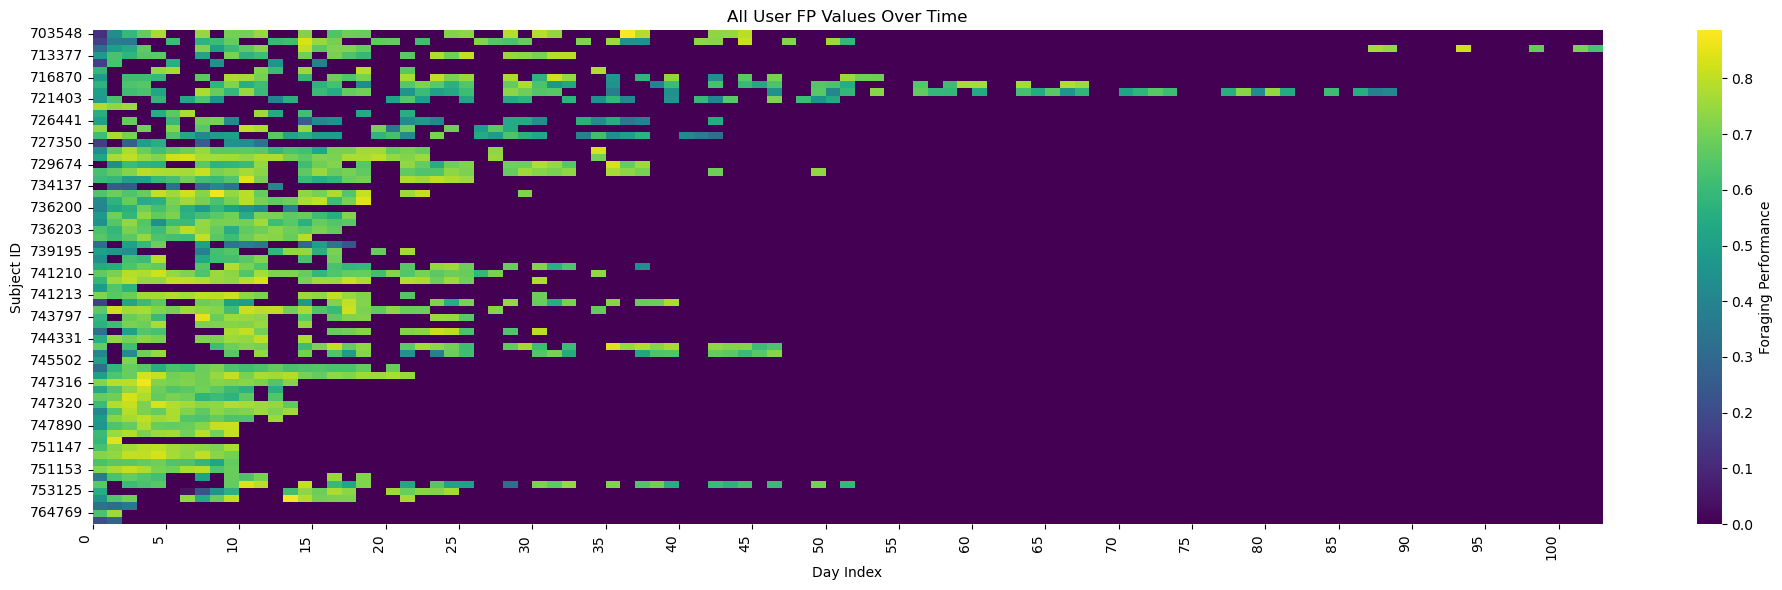

In [18]:
# Plot foraging performance heatmap for all users

plt.figure(figsize=(20,6))
sns.heatmap(data=df, cmap='viridis', cbar_kws={'label': 'Foraging Performance'})

n = df.shape[1]
step=5
tick_positions = np.arange(0, n, step)
tick_labels = df.columns[::step]

plt.xticks(tick_positions, tick_labels, rotation=90, ha='right')
plt.title('All User FP Values Over Time')
plt.xlabel('Day Index')
plt.ylabel('Subject ID')

plt.tight_layout()
plt.show()

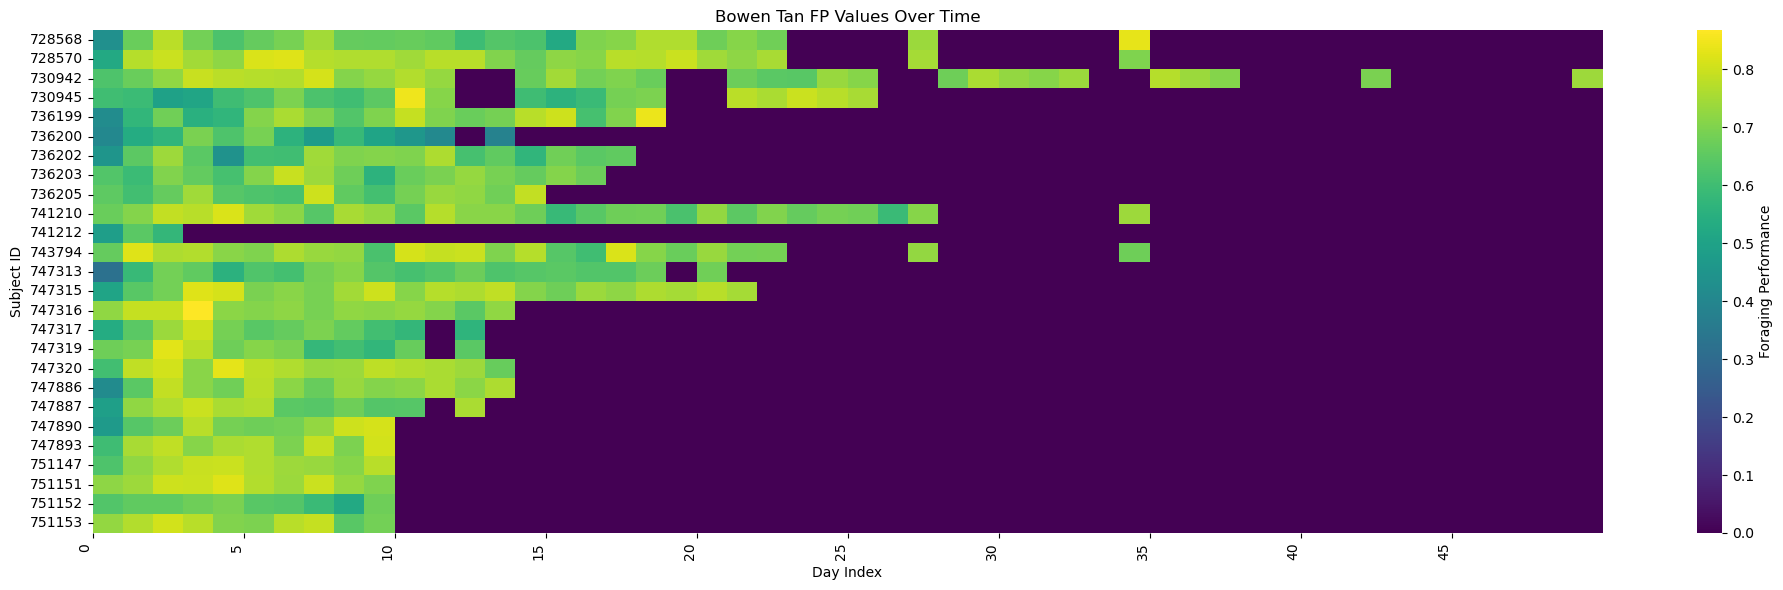

In [19]:
# Plot foraging performance heatmap for select user

# Exclude train_by_others column 
select_df = select_df.drop(columns='trained_by_others')

plt.figure(figsize=(20,6))
sns.heatmap(data=select_df, cmap='viridis', cbar_kws={'label': 'Foraging Performance'})

n = select_df.shape[1]
step=5
tick_positions = np.arange(0, n, step)
tick_labels = select_df.columns[::step]

plt.xticks(tick_positions, tick_labels, rotation=90, ha='right')
plt.title(f'{user} FP Values Over Time')
plt.xlabel('Day Index')
plt.ylabel('Subject ID')

plt.tight_layout()
plt.show()

In [20]:
def analyze_subject(row):

    # Find non-zero values and idxs
    non_zero = row[row != 0]
    non_zero_idx = np.where(row != 0)[0]

    if len(non_zero) <= 1:
        return {'subject_id': row.name, 'continuous': True, 'breaks': 0, 'break_length': []}
    
    # Find gaps between breaks 
    gaps = np.diff(non_zero_idx)

    # If all gaps = 1, then continuous else
    if np.all(gaps == 1):
        return {'subject_id': row.name, 'continuous': True, 'breaks': 0, 'break_length': []}

    # Count gaps and lengths 
    breaks = np.sum(gaps > 1)
    break_length = gaps[gaps > 1] - 1

    return {
        'subject_id': row.name,
        'continuous': False,
        'breaks': breaks,
        'break_length': break_length.tolist()
    }

In [21]:
# For all users

results = df.apply(analyze_subject, axis=1)

results_df = pd.DataFrame(results.tolist())

continuous_subjects = results_df[results_df['continuous']]['subject_id'].tolist()
discontinuous_subjects = results_df[~results_df['continuous']]

print("Subjects with continuous foraging performance:")
print(continuous_subjects)
print("\nSubjects with breaks in foraging performance:")
for _, row in discontinuous_subjects.iterrows():
    print(f"Subject {row['subject_id']}:")
    print(f"  Number of breaks: {row['breaks']}")
    print(f"  Break lengths: {row['break_length']}")
    print()

Subjects with continuous foraging performance:
[722680, 736199, 736201, 736202, 736203, 736205, 741212, 747315, 747316, 747320, 747886, 747890, 747893, 748644, 751147, 751151, 751152, 751153, 754375, 764769, 764787]

Subjects with breaks in foraging performance:
Subject 703548:
  Number of breaks: 9
  Break lengths: [2, 1, 2, 1, 5, 2, 1, 4, 4]

Subject 704151:
  Number of breaks: 12
  Break lengths: [2, 1, 2, 2, 1, 3, 3, 1, 3, 1, 2, 2]

Subject 712031:
  Number of breaks: 6
  Break lengths: [3, 2, 68, 4, 4, 2]

Subject 713377:
  Number of breaks: 7
  Break lengths: [2, 1, 2, 1, 2, 1, 2]

Subject 716866:
  Number of breaks: 4
  Break lengths: [3, 2, 3, 2]

Subject 716868:
  Number of breaks: 6
  Break lengths: [3, 5, 1, 3, 2, 12]

Subject 716870:
  Number of breaks: 16
  Break lengths: [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 4]

Subject 720935:
  Number of breaks: 15
  Break lengths: [1, 4, 3, 1, 2, 2, 2, 2, 2, 1, 2, 4, 1, 2, 2]

Subject 720956:
  Number of breaks: 17
  Break leng

In [22]:
# For selected user

select_results = select_df.apply(analyze_subject, axis=1)

select_results_df = pd.DataFrame(select_results.tolist())

continuous_subjects = select_results_df[select_results_df['continuous']]['subject_id'].tolist()
discontinuous_subjects = select_results_df[~select_results_df['continuous']]

print("Subjects with continuous foraging performance:")
print(continuous_subjects)
print("\nSubjects with breaks in foraging performance:")
for _, row in discontinuous_subjects.iterrows():
    print(f"Subject {row['subject_id']}:")
    print(f"  Number of breaks: {row['breaks']}")
    print(f"  Break lengths: {row['break_length']}")
    print()

Subjects with continuous foraging performance:
[736199, 736202, 736203, 736205, 741212, 747315, 747316, 747320, 747886, 747890, 747893, 751147, 751151, 751152, 751153]

Subjects with breaks in foraging performance:
Subject 728568:
  Number of breaks: 2
  Break lengths: [4, 6]

Subject 728570:
  Number of breaks: 2
  Break lengths: [4, 6]

Subject 730942:
  Number of breaks: 6
  Break lengths: [2, 2, 2, 2, 4, 6]

Subject 730945:
  Number of breaks: 2
  Break lengths: [2, 2]

Subject 736200:
  Number of breaks: 1
  Break lengths: [1]

Subject 741210:
  Number of breaks: 1
  Break lengths: [6]

Subject 743794:
  Number of breaks: 2
  Break lengths: [4, 6]

Subject 747313:
  Number of breaks: 1
  Break lengths: [1]

Subject 747317:
  Number of breaks: 1
  Break lengths: [1]

Subject 747319:
  Number of breaks: 1
  Break lengths: [1]

Subject 747887:
  Number of breaks: 1
  Break lengths: [1]



In [23]:
def performance_difference(row):
    # Get the non-zero values and corrosponding idxs
    non_zero = row[row != 0]
    non_zero_idx = np.where(row != 0)[0]

    # If there are no or only one non-zero value, no breaks exist
    if len(non_zero_idx) <= 1:
        return {
            'subject_id': row.name,
            'mean_performance_difference': 0,
            'absolute_performance_difference': 0,
            'num_breaks': 0,
            'average_break_length': 0
        }

    # Find the idxs where there are gaps
    breaks = np.where(np.diff(non_zero_idx) > 1)[0]
    
    # If no gaps found, return the default values
    if len(breaks) == 0:
        return {
            'subject_id': row.name,
            'mean_performance_difference': 0,
            'absolute_performance_difference': 0,
            'num_breaks': 0,
            'average_break_length': 0
        }

    differences = []
    break_lengths = []
    
    for i in range(len(breaks)):
        # Calculate the fp differences before and after the gap
        last_value_before = non_zero.iloc[breaks[i]]
        first_value_after = non_zero.iloc[breaks[i] + 1]
        
        # - differences = decrease in learning
        # + differences = increase in learning
        differences.append(first_value_after - last_value_before)

        # Calculate length of the gap
        break_length = non_zero_idx[breaks[i] + 1] - non_zero_idx[breaks[i]] - 1
        break_lengths.append(break_length)

    # mean_difference = average, abs_difference = summed changes regardless of gap length, average_break_length = average gap length for a subject
    mean_difference = sum(differences) / len(differences)
    abs_difference = sum(differences)
    average_break_length = sum(break_lengths) / len(break_lengths)

    return {
        'subject_id': row.name,
        'mean_performance_difference': mean_difference,
        'absolute_performance_difference': abs_difference,
        'num_breaks': len(breaks),
        'average_break_length': average_break_length
    }


In [24]:
# All user results
results1 = df.apply(performance_difference, axis=1)
results_df = pd.DataFrame(results1.tolist())

# Select user results
results2 = select_df.apply(performance_difference, axis=1)
select_results_df = pd.DataFrame(results2.tolist())

In [25]:
# For further analysis see notes

In [26]:
# Clean - only show non-zero performance differences/gap amounts
cleaned_df = results_df[(results_df['mean_performance_difference'] != 0) | (results_df['num_breaks'] != 0)]
select_cleaned_df = select_results_df[(select_results_df['mean_performance_difference'] != 0) | (select_results_df['num_breaks'] != 0)]

# Sort
cleaned_df = cleaned_df.sort_values('num_breaks', ascending=False)
select_cleaned_df = select_cleaned_df.sort_values('num_breaks', ascending=False)

# Reset index
cleaned_df.reset_index(drop = True)
select_cleaned_df.reset_index(drop = True)


pd.set_option('display.float_format', '{:.2f}'.format)
print(f'All users: {cleaned_df.to_string(index=False)}')
print(f'Select user: {user}: {select_cleaned_df.to_string(index=False)}')

All users:  subject_id  mean_performance_difference  absolute_performance_difference  num_breaks  average_break_length
     720956                         0.02                             0.28          17                  2.24
     716870                         0.01                             0.23          16                  1.56
     720935                        -0.00                            -0.05          15                  2.07
     753124                        -0.01                            -0.17          14                  1.64
     704151                         0.05                             0.55          12                  1.92
     721403                        -0.01                            -0.17          12                  2.08
     744744                        -0.04                            -0.39          10                  2.20
     703548                         0.00                             0.00           9                  2.44
     743793      

<Axes: xlabel='average_break_length', ylabel='mean_performance_difference'>

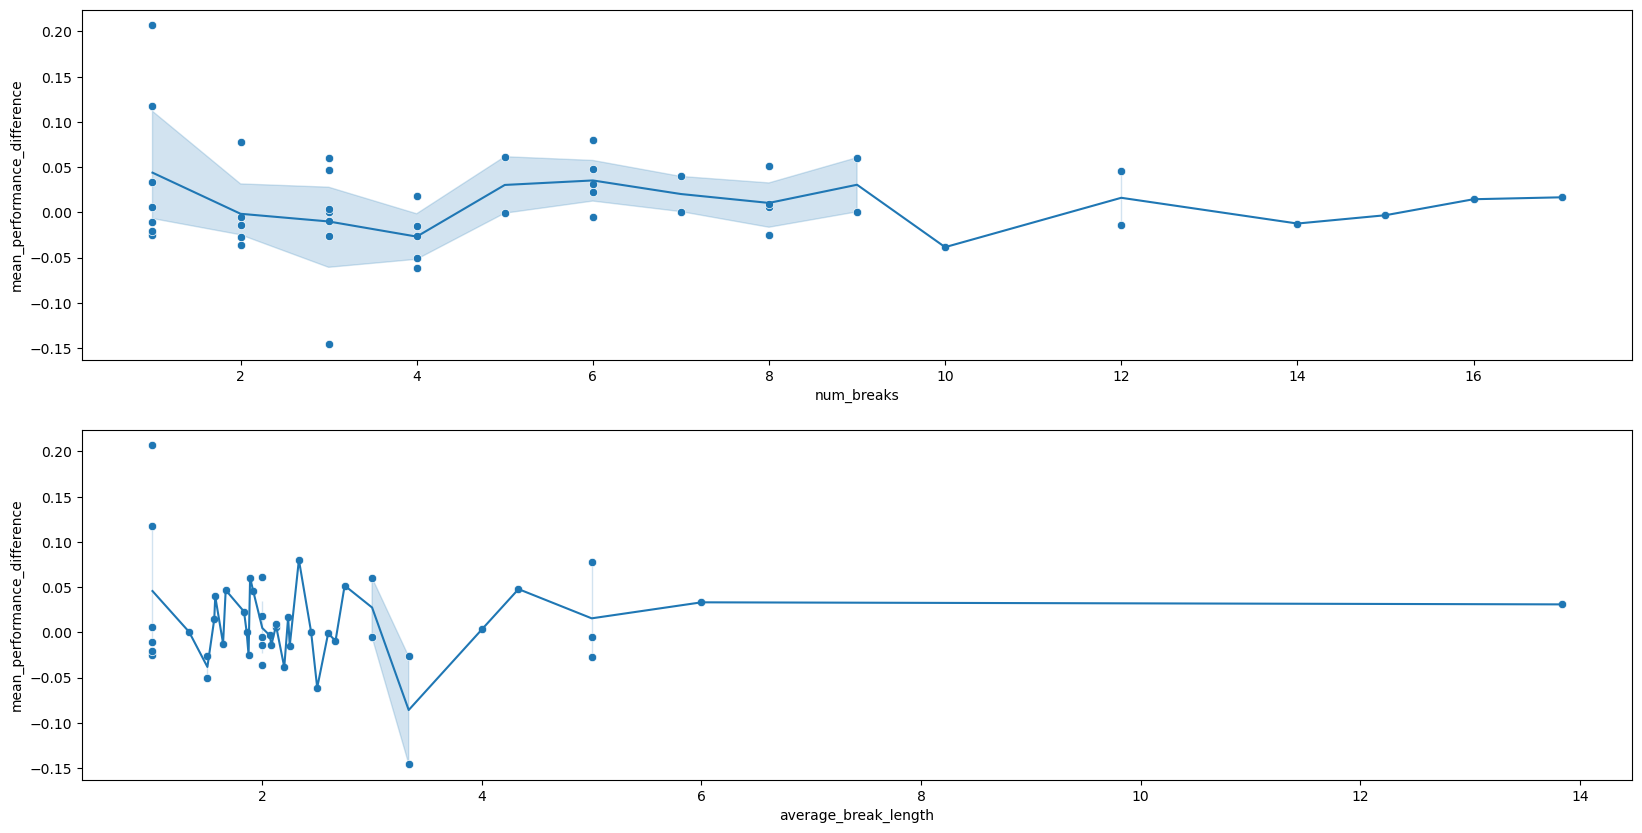

In [27]:
# Plots for all users

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(cleaned_df, x='num_breaks', y='mean_performance_difference', ax=ax1)
sns.scatterplot(cleaned_df, x='num_breaks', y='mean_performance_difference', ax=ax1)

sns.lineplot(cleaned_df, x='average_break_length', y='mean_performance_difference', ax=ax2)
sns.scatterplot(cleaned_df, x='average_break_length', y='mean_performance_difference', ax=ax2)

<Axes: xlabel='num_breaks', ylabel='mean_performance_difference'>

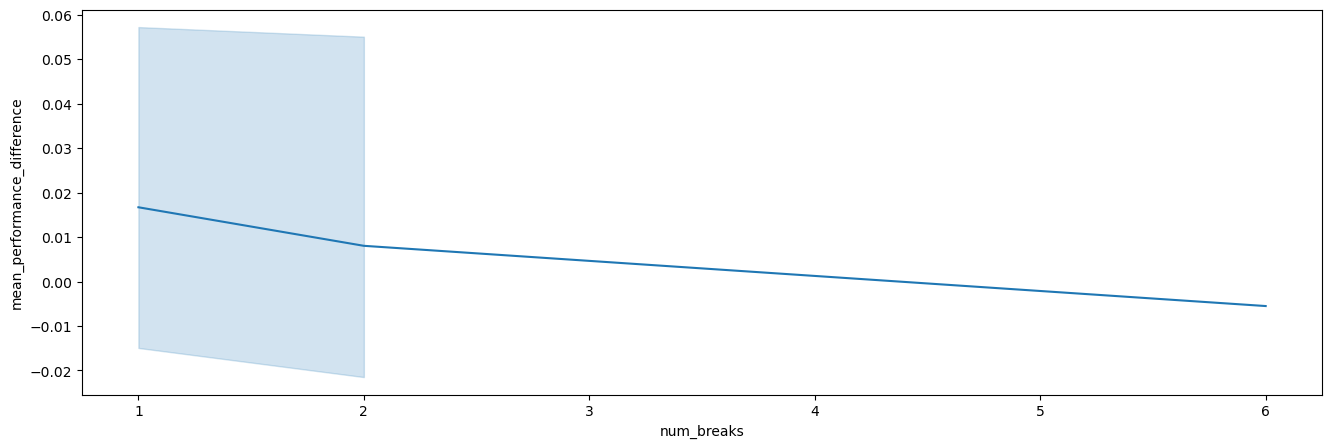

In [28]:
# Plot of selected user 

plt.figure(figsize=(16,5))

sns.lineplot(select_cleaned_df, x='num_breaks', y='mean_performance_difference')